# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: July 13, 2022
* Student Name: David Siamon
* Student Net ID: dws3qd
* This URL: <a URL to the notebook source of this document>
* GitHub Repo URL: 

# The Monte Carlo Module

In [1]:
import numpy as np
import pandas as pd
import random

class Die():
    '''
    A Die object contains an array of faces and a weight associated to each face.
    The weights are stored in an array of their own and are paired with the faces by index.
    A Die can adjust its weights after initialization.
    A Die can be "rolled" to select a face.
    '''

    def __init__(self, name, arr):
        '''
        Initializes a Die object. name and arr are passed in and set to their respective attributes,
        and weights are all set to 1.0. Additionally, a private DataFrame is initialized, storing the
        faces alongside their weights.

        The array must contain either all strings or all numbers, otherwise initialization will fail.
        In this case, all attributes are set to None.
        '''
        sametype = True
        arrtype = type(arr[0])
        for elm in arr:
            if type(elm) != arrtype:
                sametype = False
        if sametype and arrtype is (str or int or float):
            self._name = name
            self.faces = arr
            self.weights = []
            for i in range(len(arr)):
                self.weights.append(1.0)
            self._df = pd.DataFrame([self.faces, self.weights]).T
            self._df.columns = ["Face", "Weight"]
        else:
            print(arrtype)
            print("Error: All faces must be of same type and either strings or numbers.")
    
    def change_weight(self, face, weight):
        '''
        Changes one weight of the weights attribute. Takes in two params, a face to change the weight of
        and the new weight. Only changes the weight if both params are valid. Returns a boolean indicating
        whether the change was successful (True = weight changed).
        '''
        if face not in self.faces:
            print("Error: " + str(face) + " not in faces DataFrame.")
            return False
        elif not ( isinstance(weight, float) or isinstance(weight, int)):
            print("Error: Weight param is not a int or float.")
            return False
        else:
            i = self.faces.index(face)
            self.weights[i] = float(weight)
            self._df.iloc[i,1] = weight
            return True

    def roll(self, n=1):
        '''
        "Rolls" the Die object n times. n defaults to 1 if not otherwise indicated.
        A Die roll consists of selecting a face from the faces attribute, where faces with larger weights 
        are more likely to be selected.
        
        i.e a face with weight 5.0 is five times as likely to be selected as a face with weight 1.0.

        The list of all faces rolled during the method's execution is returned.
        '''
        lst = random.choices(self.faces, self.weights, k=n)
        return lst

    def get_df(self):
        '''
        A getter method to access the Die's private DataFrame attribute.
        '''
        return self._df

    def get_name(self):
        '''
        A getter method to access the Die's private name attribute.
        '''
        return self._name

class Game():
    '''
    A game entails rolling one or more Die objects, one or more times. Results of most recent game are stored in a private DataFrame.
    '''

    _df = pd.DataFrame()

    def __init__(self, dice):
        '''
        Initializes a Game object with a dice attribute containing one
        or more Die objects. Each Die must contain the same faces, otherwise init fails.
        '''
        eq = True
        valid_faces = sorted(dice[0].faces)
        for die in dice:
            if sorted(die.faces) != valid_faces:
                eq = False
        if eq:
            self.dice = dice
        else:
            print("Error: Die face values not equivalent throughout list. Game construction failed.")

    def play(self, n):
        '''
        Rolls each Die object n times. Stores results of the rolls in the Game private DataFrame with each roll as a row and 
        each Die as a column.
        '''
        self._df = pd.DataFrame()
        for i in range(n):
            lst = []
            for die in self.dice:
                lst.append(die.roll()[0])
            temp_df = pd.DataFrame(data=lst)
            self._df = pd.concat([self._df, temp_df.T])
        indices = np.arange(1, n+1)
        self._df = self._df.set_index(indices)
        cols = [d.get_name() for d in self.dice]
        self._df.columns = cols

    def show_df(self, width="wide"):
        '''
        A getter method to access the Game's private DataFrame attribute. Takes an optional param to display the DataFrame
        as "narrow", with a double-index for rolls and dice.
        '''
        if width == "wide":
            return self._df
        elif width == "narrow":
            narrow = self._df.stack()
            narrow.index.names = ["Roll", "Die"]
            return narrow
        else:
            print("Error: Width parameter must be wide or narrow.")
            return    

class Analyzer():
    '''
    This class takes in a completed Game object and calculates various descriptive statistics on the game results.
    '''

    jackpot_df = pd.DataFrame()
    combos_df = pd.DataFrame()
    face_counts_df = pd.DataFrame()

    def __init__(self, game):
        '''
        Initializes the Analyzer object with the game passed in. This method also determines the type of the face values
        on the dice used in the game.
        '''
        self.game = game
        self.face_type = type(self.game.dice[0].faces[0])

    def jackpot(self):
        '''
        This method returns the number of times the game had a "jackpot", meaning all face values were the same on a given roll.

        The jackpot data is stored in the Analyzer's jackpot_df attribute, which contains a row for each roll and a corresponding
        boolean value for whether or not the roll had a jackpot.
        '''
        n = 0
        df = self.game.show_df()
        for index, row in df.iterrows():
            if len(set(row)) == 1:
                n += 1
                temp_df = pd.DataFrame([index, True])
                self.jackpot_df = pd.concat([self.jackpot_df, temp_df.T])
            else:
                temp_df = pd.DataFrame([index, False])
                self.jackpot_df = pd.concat([self.jackpot_df, temp_df.T])
        self.jackpot_df = self.jackpot_df.set_index(0)
        return n

    def combo_counts(self):
        '''
        This method fills in the combos_df DataFrame such that each row contains a combination that was rolled in the game
        and its number of times rolled. Does not return a value but prints a statement indicating that the combos_df was
        successfully updated.
        '''
        game_df = self.game.show_df()
        combos = {}
        for index, row in game_df.iterrows():
            lst = row.values.flatten().tolist()
            lst.sort()
            s = "(" + ", ".join(str(e) for e in lst) + ")"
            if s in combos.keys():
                combos[s] += 1
            else:
                combos[s] = 1
        self.combos_df = pd.DataFrame(list(combos.items())).sort_values(1, ascending=False)
        print("Combination DataFrame Updated Successfully.")

    def face_counts_per_roll(self):
        '''
        This method fills in the face_counts DataFrame where each row corresponds to a roll, each column is a different
        face value of the set of dice, and the data represents the number of times each face was rolled on a given roll.
        Does not return a value but prints a statement indicating that the face_counts_df was successfully updated.
        '''
        df = self.game.show_df()
        faces = self.game.dice[0].faces
        for index, row in df.iterrows():
            face_counts = {}
            for elm in faces:
                face_counts[elm] = 0
            for r in row:
                face_counts[r] += 1
            temp_df = pd.DataFrame(list(face_counts.items())).set_index(0)
            self.face_counts_df = pd.concat([self.face_counts_df, temp_df.T])
        indices = np.arange(1, len(self.face_counts_df)+1)
        self.face_counts_df = self.face_counts_df.set_index(indices)
        self.face_counts_df.index.names = ["Roll #"]
        print("Face Counts DataFrame Updated Successfully.")

# Test Module

In [2]:
import unittest
import pandas as pd
from montecarlo import Die, Game, Analyzer

class MontecarloTestSuite(unittest.TestCase):

    def test_00_die_init(self):
        '''
        Confirms that the init method correctly sets the weights array to 1.0 values of a correct length.
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        self.assertTrue(die1.weights == [1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

    def test_001_die_change_weight(self): 
        '''
        Tests to confirm that we can validly add a weight and see the change refleccted in the "weights" array.
        Additionally, confirms that the weights are set to floats even if the method takes in an int.
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        die1.change_weight("four", 2)
        self.assertTrue(die1.weights == [1.0, 1.0, 1.0, 2.0, 1.0, 1.0])

    def test_002_die_change_weight(self):
        '''
        Tries to change the weight of a face that doesn't exist.
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        self.assertFalse(die1.change_weight("seven", 2))
    
    def test_003_die_change_weight(self):
        '''
        Tries to change the weight of a face to an invalid value.
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        self.assertFalse(die1.change_weight("four", "notanintorfloat"))

    def test_004_die_roll(self):
        '''
        Ensures that only valid faces end up in the roll's output.
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        lst = die1.roll()
        self.assertTrue([elm in die1.faces for elm in lst])

    def test_005_die_roll(self):
        '''
        Ensures that the output list has a length equal to the "n" parameter.
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        self.assertTrue(len(die1.roll(5)) == 5)

    def test_006_die_get_df(self):
        '''
        Ensures that the method returns a DataFrame with correct values.
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        expected_df = pd.DataFrame([["one", "two", "three", "four", "five", "six"], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]).T
        expected_df.columns = ["Face", "Weight"]
        self.assertTrue(die1.get_df().equals(expected_df))

    def test_007_die_get_name(self):
        '''
        Ensures that the correct name is returned.
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        self.assertTrue(die1.get_name() == "die1")

    def test_100_game_init(self):
        '''
        Checks that length of created dice attribute matches length of input array. Input array has identical dice.
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        die2 = Die("die2", ["one", "two", "three", "four", "five", "six"])
        die3 = Die("die3", ["one", "two", "three", "four", "five", "six"])
        die4 = Die("die4", ["one", "two", "three", "four", "five", "six"])
        die5 = Die("die5", ["one", "two", "three", "four", "five", "six"])
        game1 = Game([die1, die2, die3, die4, die5])
        self.assertTrue(len(game1.dice) == 5)

    def test_101_game_init(self):
        '''
        Attempts to pass in dice containing different faces. Ensures that no dice attribute is assigned due to the incorrect input.
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        die2 = Die("die2", ["one", "two", "three", "four", "five", "six"])
        die3 = Die("die3", ["one", "two", "three", "four", "five", "six"])
        die4 = Die("die4", ["one", "two", "three", "four", "five", "six"])
        die5 = Die("die5", ["one", "two", "three", "four", "five", "seven"]) # six changed to seven
        game1 = Game([die1, die2, die3, die4, die5])
        self.assertFalse(hasattr(game1, 'dice'))

    def test_102_game_play(self):
        '''
        Plays a game with 20 rolls. Ensures that the DataFrame attribute has 20 rows and 5 columns (for the 5 Die objects).
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        die2 = Die("die2", ["one", "two", "three", "four", "five", "six"])
        die3 = Die("die3", ["one", "two", "three", "four", "five", "six"])
        die4 = Die("die4", ["one", "two", "three", "four", "five", "six"])
        die5 = Die("die5", ["one", "two", "three", "four", "five", "six"])
        game1 = Game([die1, die2, die3, die4, die5])
        game1.play(20)
        self.assertTrue(game1._df.shape == (20, 5))

    def test_103_game_play(self):
        '''
        Plays two consecutive games, first with 20 rolls and second with 25 rolls. Ensures that only the second game's results
        are stored in the DataFrame attribute, i.e the df's shape is 25 rows and 5 columns.
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        die2 = Die("die2", ["one", "two", "three", "four", "five", "six"])
        die3 = Die("die3", ["one", "two", "three", "four", "five", "six"])
        die4 = Die("die4", ["one", "two", "three", "four", "five", "six"])
        die5 = Die("die5", ["one", "two", "three", "four", "five", "six"])
        game1 = Game([die1, die2, die3, die4, die5])
        game1.play(20)
        game1.play(25)
        self.assertTrue(game1._df.shape == (25, 5))

    def test_104_game_show_df(self):
        '''
        Plays one game, then checks that the show_df method (in wide form) returns the DataFrame attribute identically.
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        die2 = Die("die2", ["one", "two", "three", "four", "five", "six"])
        die3 = Die("die3", ["one", "two", "three", "four", "five", "six"])
        die4 = Die("die4", ["one", "two", "three", "four", "five", "six"])
        die5 = Die("die5", ["one", "two", "three", "four", "five", "six"])
        game1 = Game([die1, die2, die3, die4, die5])
        game1.play(20)
        self.assertTrue(game1._df.equals(game1.show_df()))

    def test_105_game_show_df(self):
        '''
        Plays one game. Calls the show_df method with the "narrow" parameter. Ensures that the shape of the narrow DataFrame
        is now a single value, equal to (the number of dice) * (the number of rolls).
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        die2 = Die("die2", ["one", "two", "three", "four", "five", "six"])
        die3 = Die("die3", ["one", "two", "three", "four", "five", "six"])
        die4 = Die("die4", ["one", "two", "three", "four", "five", "six"])
        die5 = Die("die5", ["one", "two", "three", "four", "five", "six"])
        game1 = Game([die1, die2, die3, die4, die5])
        num_dice = len(game1.dice)
        num_rolls = 20
        expected_shape = num_dice * num_rolls
        game1.play(num_rolls)
        narrow_df = game1.show_df("narrow")
        self.assertTrue(narrow_df.shape == (expected_shape,))

    def test_200_analyzer_init(self):
        '''
        Initializes an Analyzer object and confirms its type attribute is correct.
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        die2 = Die("die2", ["one", "two", "three", "four", "five", "six"])
        die3 = Die("die3", ["one", "two", "three", "four", "five", "six"])
        die4 = Die("die4", ["one", "two", "three", "four", "five", "six"])
        die5 = Die("die5", ["one", "two", "three", "four", "five", "six"])
        expected_face_type = str
        game1 = Game([die1, die2, die3, die4, die5])
        game1.play(20)
        analyzer1 = Analyzer(game1)
        self.assertTrue(analyzer1.face_type == expected_face_type)

    def test_201_analyzer_jackpot(self):
        '''
        Creates a game object that guarantees that every roll will be a jackpot (two faces, one with weight 0.0). Ensures
        that jackpot method's output matches the number of rolls.
        '''
        die1 = Die("die1", ["one", "two"])
        die2 = Die("die2", ["one", "two"])
        die1.change_weight("one", 0)
        die2.change_weight("one", 0)
        game1 = Game([die1, die2])
        num_rolls = 20
        game1.play(num_rolls)
        analyzer1 = Analyzer(game1)
        self.assertTrue(analyzer1.jackpot() == num_rolls)

    def test_202_analyzer_combo_counts(self):
        '''
        Creates a game object that is virtually guaranteed to have three different combinations. Check that after calling 
        this method, the combos_df attribute has three rows.
        '''
        die1 = Die("die1", ["one", "two"])
        die2 = Die("die2", ["one", "two"])
        game1 = Game([die1, die2])
        game1.play(100) # 100 rolls virtually guarantees that each of the three possible combos will occur one or more times.
        analyzer1 = Analyzer(game1)
        analyzer1.combo_counts()
        self.assertTrue(len(analyzer1.combos_df) == 3)

    def test_203_analyzer_face_counts_per_roll(self):
        '''
        Creates a game object that plays a 100-roll game. The dice have six faces each. Ensures that the face_counts_df attribute
        has shape (100, 6).
        '''
        die1 = Die("die1", ["one", "two", "three", "four", "five", "six"])
        die2 = Die("die2", ["one", "two", "three", "four", "five", "six"])
        die3 = Die("die3", ["one", "two", "three", "four", "five", "six"])
        die4 = Die("die4", ["one", "two", "three", "four", "five", "six"])
        die5 = Die("die5", ["one", "two", "three", "four", "five", "six"])
        game1 = Game([die1, die2, die3, die4, die5])
        game1.play(100)
        analyzer1 = Analyzer(game1)
        analyzer1.face_counts_per_roll()
        self.assertTrue(analyzer1.face_counts_df.shape == (100, 6))
        
# if __name__ == '__main__':

#     unittest.main(verbosity=3)

# Test Results

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

## Scenario 1

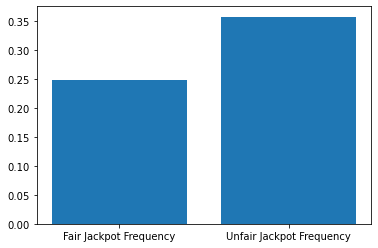

In [4]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

fair_coin = Die("fair_coin", ["Heads", "Tails"])
unfair_coin = Die("unfair_coin", ["Heads", "Tails"])
unfair_coin.change_weight("Heads", 5.0)

fair_game = Game([fair_coin, fair_coin, fair_coin])
fair_game.play(1000)
unfair_game = Game([unfair_coin, unfair_coin, fair_coin])
unfair_game.play(1000)

fair_analyzer = Analyzer(fair_game)
unfair_analyzer = Analyzer(unfair_game)

fair_jackpot_frequency = fair_analyzer.jackpot() / 1000
unfair_jackpot_frequency = unfair_analyzer.jackpot() / 1000

plt.bar(["Fair Jackpot Frequency", "Unfair Jackpot Frequency"], height=[fair_jackpot_frequency, unfair_jackpot_frequency])
plt.show();

## Scenario 2

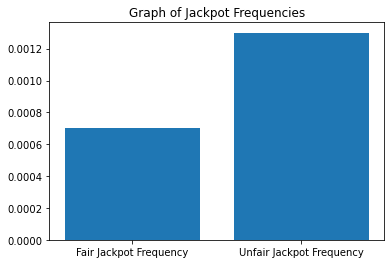

Combination DataFrame Updated Successfully.
Combination DataFrame Updated Successfully.


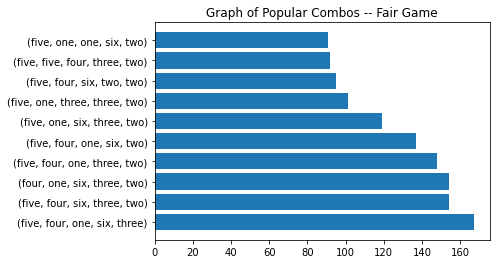

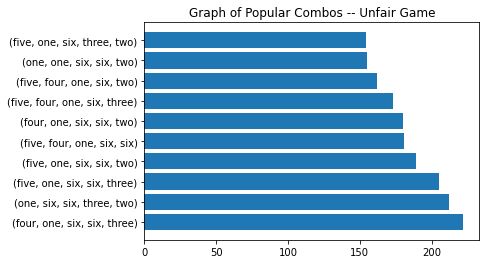

In [5]:
fair_die = Die("fair_die", ["one", "two", "three", "four", "five", "six"])
unfair_die1 = Die("unfair_die1", ["one", "two", "three", "four", "five", "six"])
unfair_die1.change_weight("six", 5.0)
unfair_die2 = Die("unfair_die2", ["one", "two", "three", "four", "five", "six"])
unfair_die2.change_weight("one", 5.0)

fair_game = Game([fair_die, fair_die, fair_die, fair_die, fair_die])
unfair_game = Game([unfair_die1, unfair_die1, unfair_die2, fair_die, fair_die])
fair_game.play(10000)
unfair_game.play(10000)

fair_analyzer = Analyzer(fair_game)
unfair_analyzer = Analyzer(unfair_game)

fair_jackpot_frequency = fair_analyzer.jackpot() / 10000
unfair_jackpot_frequency = unfair_analyzer.jackpot() / 10000

graph1 = plt.bar(["Fair Jackpot Frequency", "Unfair Jackpot Frequency"], height=[fair_jackpot_frequency, unfair_jackpot_frequency])
plt.title("Graph of Jackpot Frequencies")
plt.show()

fair_analyzer.combo_counts()
unfair_analyzer.combo_counts()
fair_combos = fair_analyzer.combos_df.head(10)
unfair_combos = unfair_analyzer.combos_df.head(10)

graph2 = plt.barh(fair_combos[0], width=fair_combos[1])
plt.title("Graph of Popular Combos -- Fair Game")
plt.show()
graph3 = plt.barh(unfair_combos[0], width=unfair_combos[1])
plt.title("Graph of Popular Combos -- Unfair Game")
plt.show()

## Scenario 3

In [26]:
a_thru_z = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
freq_df = pd.read_csv("letter-freqs.csv", header=None, sep='\t')
alphabet = Die("alphabet", a_thru_z)
for i in range(26):
    alphabet.change_weight(a_thru_z[i], freq_df.iloc[i,1])
game1 = Game([alphabet, alphabet, alphabet, alphabet, alphabet])
game1.play(1000)
potential_words = []
for index, row in game1._df.iterrows():
    lst = row.values.flatten().tolist()
    s = "".join(str(e) for e in lst)
    potential_words.append(s)
for word in random.sample(potential_words, 50):
    print(word)

eoasr
ryies
tesif
oseqa
oopna
aelfg
delwa
fciee
mmnlo
setrc
naelt
agior
gcoio
olnif
igick
ufceu
iofss
evbna
folsh
licoh
nafta
eaoeo
eprsl
ueccs
sdree
iihie
yiuml
oorus
isooe
aeicm
sgege
tnemh
sneli
rsrpe
hurac
ialer
tkler
harco
culad
nmbnl
bonii
relut
tdkgi
uloga
sirfe
iuoto
loiro
ehpaz
oiore
elcib


I'll count "nafta" even though its only real-world meaning is an abbreviation for the North American Free Trade Agreement. For thoroughness, I looked up "agior", "folsh", "hurac", "halco", "relut", and "sirfe" in the English Dictionary. None of them are words, but they seem like they could be.

This totals 7/50 words that "look" like real words, yielding a frequency of 14%. Since this was a random sample, we'll assume that frequency is roughly accurate for the entire Game instance. I would make a confidence interval, but I won't know how to do that until summer session 3.

# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [7]:
!ls -lRF -o

total 336
-rw-r--r--@ 1 davidsiamon  103676 Jul 14 09:21 FinalProjectSubmissionTemplate.ipynb
-rw-r--r--  1 davidsiamon   35149 Jul 13 21:36 LICENSE
-rw-r--r--  1 davidsiamon      18 Jul 13 21:36 README.md
drwxr-xr-x  4 davidsiamon     128 Jul 13 21:54 __pycache__/
-rw-r--r--@ 1 davidsiamon     234 Jul 13 20:51 letter-freqs.csv
drwxr-xr-x  4 davidsiamon     128 Jul 14 09:25 montecarlo_package/
-rw-r--r--@ 1 davidsiamon    9984 Jul 13 22:01 montecarlo_test.py
-rw-r--r--@ 1 davidsiamon    2873 Jul 13 21:58 montecarlo_test_output.txt
-rw-r--r--  1 davidsiamon     378 Jul 14 09:28 setup.py

./__pycache__:
total 48
-rw-r--r--  1 davidsiamon  8662 Jul 13 21:52 montecarlo.cpython-39.pyc
-rw-r--r--  1 davidsiamon  9124 Jul 13 21:54 montecarlo_test.cpython-39.pyc

./montecarlo_package:
total 32
-rw-r--r--  1 davidsiamon    40 Jul 14 09:25 __init__.py
-rw-r--r--@ 1 davidsiamon  8313 Jul 13 21:51 montecarlo.py


# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [31]:
# Installation commands